The naming of variables, columns etc. is according to the in the paper.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import missingno as msno
import seaborn as sns
import joblib
import os
from tqdm import tqdm
from sklearn.metrics import r2_score, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from scipy import stats
import itertools

In [2]:
# see footnote [22]
columns = ["b/m", "de", "dfr", "dfy", "dp", "dy", "ep", "infl", "ltr", "lty", "ntis", "svar", "tbl", "tms", "lag_returns"]

nber = pd.read_csv("data/NBER_20210719_cycle_dates_pasted.csv")[1:]
nber["peak"] = pd.to_datetime(nber["peak"])
nber["trough"] = pd.to_datetime(nber["trough"])

data_raw = pd.read_csv("data/PredictorData2021 - Monthly.csv")
data_raw["yyyymm"] = pd.to_datetime(data_raw["yyyymm"], format='%Y%m', errors='coerce')
data_raw["Index"] = data_raw["Index"].str.replace(",", "")
data_raw = data_raw.set_index("yyyymm")
data_raw[data_raw.columns] = data_raw[data_raw.columns].astype(float)
data_raw = data_raw.rename({"Index":"prices"}, axis=1)

# Calculate missing columns according to the explaination in m Welch and Goyal (2008) 
data_raw["dfy"] = data_raw["BAA"] - data_raw["AAA"]
data_raw["tms"] = data_raw["lty"] - data_raw["tbl"]
data_raw["de"] = np.log(data_raw["D12"]) - np.log(data_raw["E12"])
data_raw["dfr"] = data_raw["corpr"] - data_raw["ltr"]
data_raw["lag_price"] = data_raw["prices"].shift()
data_raw["dp"] = np.log(data_raw["D12"]) - np.log(data_raw["prices"])
data_raw["dy"] = np.log(data_raw["D12"]) - np.log(data_raw["lag_price"])
data_raw["ep"] = np.log(data_raw["E12"])  - np.log(data_raw["prices"])

data_raw["returns"] = data_raw["prices"].pct_change()
data_raw["lag_returns"] = data_raw["returns"].shift()

returns = data_raw["returns"].copy()
prices = data_raw["prices"].copy()

data = data_raw[columns].dropna()
returns = returns[returns.index.isin(data.index)]

# Standarize data

> We volatility standardize returns and predictors using backward-looking standard deviations that preserve the out-of-sample nature of our forecasts. 

> Returns are standardized by their trailing 12-month return standard deviation (to capture their comparatively fastmoving conditional volatility), while predictors are standardized using an expanding window historical standard deviation (given the much higher persistence of most predictors). 

> We require 36 months of data to ensure that we have enough stability in our initial predictor standardization, so the final sample that we bring to our analysis begins in 1930. We perform this standardization to align the empirical analysis with our homoskedastic theoretical setting, **but our results are insensitive to this step (none of our findings are sensitive to variations in how standardizations are implemented)**

I did try a few different normalizations and the end results seems to be nearly the same.

In [3]:
for col in columns:
    data[col] = (data[col] - data[col].expanding(36).mean())/data[col].expanding(36).std()
# Standarize return by the std of the last 12 values
returns_std = returns.rolling(12).std().shift()
returns = returns / returns_std

data = data[36:]
returns = returns[36:]

# Random Fourier Features

In [4]:
data = data[columns].copy()
nr_features = 6000
if f"data_{nr_features}.parquet" not in os.listdir("data"):
    print("Calculating omegas.")
    omegas, rff_names, rff_features = [], [], []
    for i in tqdm(range(nr_features)): # 6000*2 == 12000 == P
        omega = np.random.normal(0, 2, len(columns))
        rff_names.append(f"sin_{i}")
        rff_names.append(f"cos_{i}")
        rff_features.append(np.sin(data[columns] @ omega))
        rff_features.append(np.cos(data[columns] @ omega))
        omegas.append(omega)
    data[rff_names] = np.vstack(rff_features).T
    joblib.dump(omegas, f"data/omegas_{nr_features}.joblib")
    data.to_parquet(f"data/data_{nr_features}.parquet")

else:
    omegas = joblib.load(f"data/omegas_{nr_features}.joblib")
    data = pd.read_parquet(f"data/data_{nr_features}.parquet")
    print("data & omegas.joblib loaded.")

print("Shape of data after generating RFFs:", data.shape)

data & omegas.joblib loaded.
Shape of data after generating RFFs: (1105, 12015)


# Model

In [55]:
z_values = np.logspace(-3, 6, 10)
t_values = list(range(12, data.shape[0]))
P_values = list(range(2, 24)) + list(range(24, 60, 3)) + list(range(60, 120, 6)) + list(range(120, 12000, 100)) + [12000]

def do_backtest(P, u, t_values):
    backtest = []
    for t in t_values[:-1]:
        regression_data = data.drop(columns, axis=1).iloc[:,0:P]

        R = returns[t-12+1:t+1].values      # y_train
        R_s = returns[t+1:t+2].values       # y_test
        R_s_index = returns[t+1:t+2].index  # y_test
        S = regression_data[t-12:t]         # X_train
        S_t = regression_data[t:t+1]        # X_test
        T, nr_cols = S.shape

        beta = Ridge(alpha=z, solver="svd", fit_intercept=False, normalize=False).fit(S, R).coef_
        beta_norm = np.sqrt((beta**2).sum())

        forecast = S_t @ beta
        timing_strategy = forecast * R_s # pi

        backtest.append({"c":P/12, "z":z, "t":t, "beta_norm":beta_norm, 
            "index":forecast.index[0], "forecast":forecast.values[0], 
            "timing_strategy_index":R_s_index[0], "timing_strategy":timing_strategy.values[0], "return":R_s[0]
        })
    backtest = pd.DataFrame(backtest).set_index("index")
    return backtest

if "simulation_backtest_progress.joblib" in os.listdir("data"):
    simulation_backtest = joblib.load("data/simulation_backtest_progress.joblib")
    done_values = pd.concat(simulation_backtest)[["c", "z"]].drop_duplicates().values
else:
    simulation_backtest = []
    done_values = []

todo = list(itertools.product(P_values, z_values))
todo = [item for item in todo if item not in done_values]

for P, z in tqdm(todo):
    backtest = do_backtest(P, z, t_values)
    simulation_backtest.append(backtest)
    joblib.dump(simulation_backtest, "data/simulation_backtest_progress_.joblib")

simulation_backtest = pd.concat(simulation_backtest)
last_p = int(simulation_backtest["c"].max()*12)
simulation_backtest.to_parquet((f"data/simulation_backtest_{last_p}.parquet"))

  0%|          | 0/462 [00:08<?, ?it/s]


KeyboardInterrupt: 

# Result

In [6]:
def calc_metrics(df):
    # timing_strategy = alpha + beta*market_return
    market_reg = LinearRegression().fit(df[["return"]], df["timing_strategy"])
    beta = market_reg.coef_[0]
    alpha = market_reg.intercept_

    time_factor = 12 # 12 to get annual values
    mean = df["timing_strategy"].mean()*time_factor
    std = df["timing_strategy"].std()*np.sqrt(time_factor)
    mean_market_return = df["return"].mean()*time_factor

    metrics = {
        "beta_norm_mean" : df["beta_norm"].mean(),
        "Market Sharpe Ratio" : (df["return"].mean()*time_factor) / (df["return"].std()*np.sqrt(time_factor)),
        "Expected Return" : mean,
        "Volatility" : std,
        "R2" : r2_score(df["return"]*beta, df["timing_strategy"]),
        "SR" : mean/std,
        "IR" : (mean - mean_market_return*beta)/std,
        "Alpha" : alpha, 
        # Does sign(forecast) match sign(return)?
        "Precision": precision_score(df["return"] > 0, df["forecast"] > 0),
        "Recall": recall_score(df["return"] > 0, df["forecast"] > 0),
        "Accuracy": accuracy_score(df["return"] > 0, df["forecast"] > 0),
    }
    return metrics

result = simulation_backtest.groupby(["z", "c"]).apply(calc_metrics)
result = pd.DataFrame(list(result.values), index=result.index).reset_index().rename({"z":"log10(z)"}, axis=1)

Note: **Footnote [25]**
> More specifically, the first column reports summary statistics for the market return with rolling 12-month volatility standardization. Thus, the buy-and-hold version of this asset is itself a basic timing strategy, where timing is inversely proportional to rolling volatility. We do this simply because the standardized market is the target in our forecasting analysis. Our results across the board are generally insensitive to, and our conclusions entirely unaffected by, whether we work with the raw or volatility standardized market return. As noted earlier, we prefer to use the volatility standardized market because it aligns more directly with our theoretical framework.

**Expected result:**

|    | High Complexity Machine |
|----|-------------------------|
|  z |                    1000 |
|  c |                    1000 |
| R2 |                      8% |
| SR | 0.46                    |
| IR | 0.31                    |

Page 48 reports R2 as "per month". The Sharpe Ratio value seems to be more fitting if you annualize the data.

The metrics are displayed blow. Compared to page 39:
- beta_norm_mean: fine
- Expected Return:fine
- Volatility: fine
- R2: **always below -10**
- Sharpe Ratio: fine
- Information Ratio: Instead of increasing from 0, it is hovering around 0-5%
- Alpha: It is decreasing instead of increasing and not starting at 0

The difference in Alpha and IR make me suspicious about my calculations. IR compares the timing strategy with the beta adjusted return and alpha is the intercept of the regression between the timing_strategy (forecast*returns) and returns.


In [7]:
result[result.c==1000]

,log10(z),c,beta_norm_mean,Market Sharpe Ratio,Expected Return,Volatility,R2,SR,IR,Alpha,Precision,Recall,Accuracy
171,0.001,1000.0,0.052484,0.523715,0.219485,1.064272,-16.895890,0.206231,0.085715,0.007602,0.602273,0.571649,0.521062
343,0.010,1000.0,0.052484,0.523715,0.219484,1.064269,-16.895961,0.206230,0.085714,0.007602,0.602273,0.571649,0.521062
515,0.100,1000.0,0.052483,0.523715,0.219471,1.064236,-16.896664,0.206224,0.085711,0.007601,0.602273,0.571649,0.521062
687,1.000,1000.0,0.052471,0.523715,0.219343,1.063909,-16.903634,0.206167,0.085676,0.007596,0.602273,0.571649,0.521062
859,10.000,1000.0,0.052357,0.523715,0.218126,1.060727,-16.967821,0.205639,0.085352,0.007545,0.602273,0.571649,0.521062
1031,100.000,1000.0,0.051290,0.523715,0.209961,1.034188,-17.285893,0.203020,0.083731,0.007216,0.602917,0.573190,0.521978
1203,1000.000,1000.0,0.043545,0.523715,0.183675,0.877559,-16.465985,0.209302,0.087390,0.006391,0.603503,0.583975,0.524725


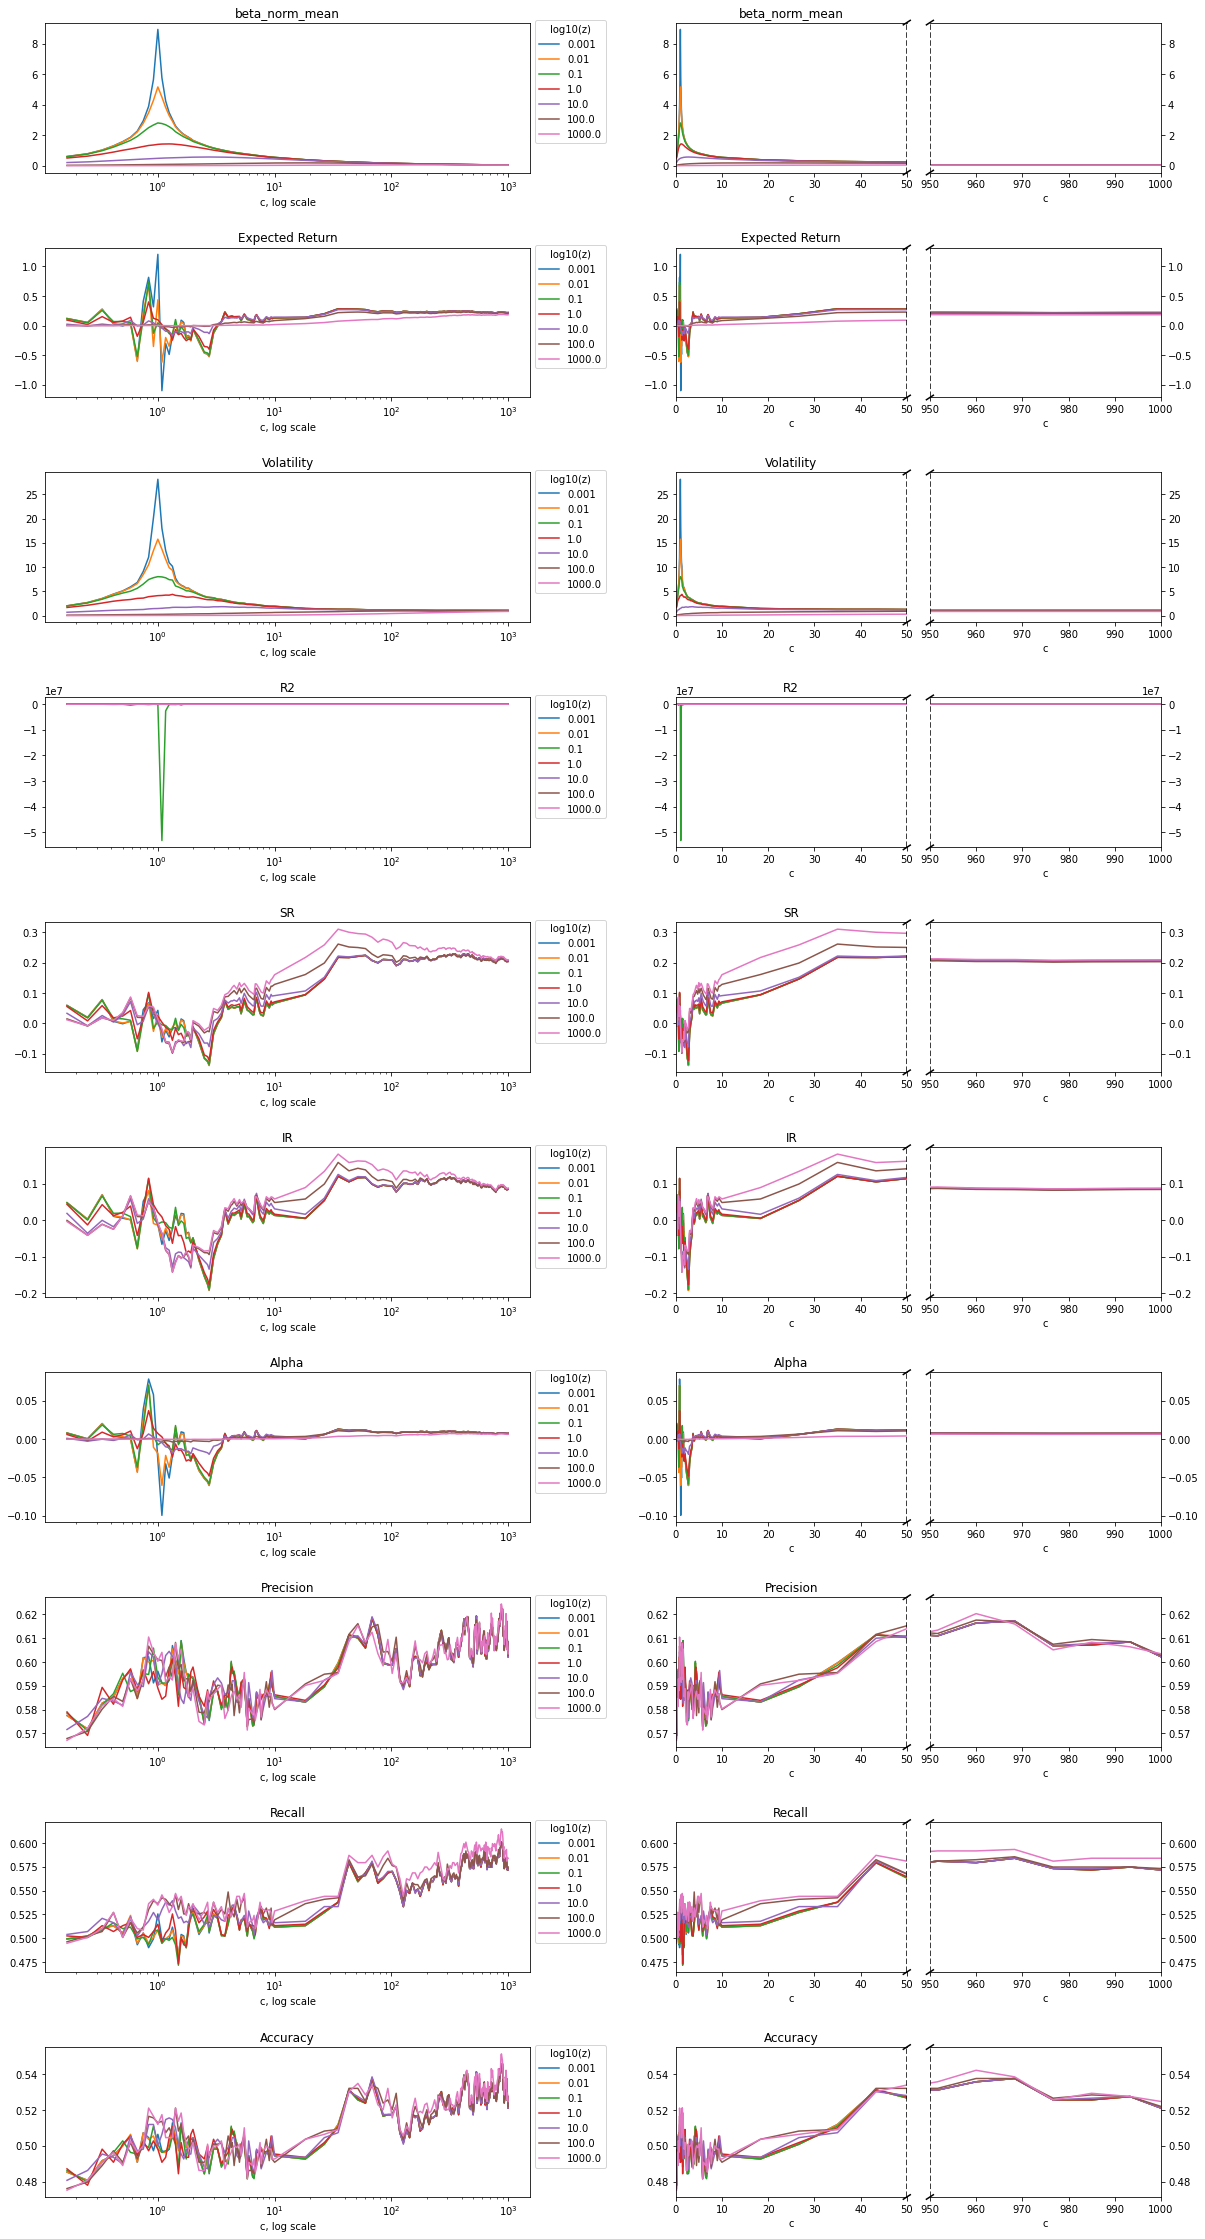

In [8]:
# https://stackoverflow.com/a/34934631/3002299

fig = plt.figure(figsize=(20, 40))
outer = gridspec.GridSpec(1, 2, wspace=0.3, hspace=0.2)

plot_cols = ["beta_norm_mean", "Expected Return", "Volatility", "R2", "SR", "IR", "Alpha", "Precision", "Recall", "Accuracy"]
for i in range(2): # Outer
    inner = gridspec.GridSpecFromSubplotSpec(10, 1, subplot_spec=outer[i], wspace=0.5, hspace=0.5)
    if i == 0:
        for j in range(10): # Inner
            col = plot_cols[j]
            ax = plt.Subplot(fig, inner[j])
            result.set_index("c").groupby("log10(z)")[col].plot(ax=ax, title=col)
            ax.legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
            ax.set_xlabel("c, log scale")
            ax.set_xscale('log')
            fig.add_subplot(ax)
    else:  
        for j in range(10): # Inner
            col = plot_cols[j]

            double_inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=inner[j], wspace=0.1, hspace=0.1)
            
            ax1 = plt.Subplot(fig, double_inner[0])
            ax2 = plt.Subplot(fig, double_inner[1])
            result.set_index("c").groupby("log10(z)")[col].plot(ax=ax1, title=col)
            result.set_index("c").groupby("log10(z)")[col].plot(ax=ax2)
            ax1.set_xlim(0, 50)
            ax2.set_xlim(950, 1000)

            ax1.axvline(x=50, linestyle="--", c="black")
            ax2.axvline(x=950, linestyle="--", c="black")

            # hide the spines between ax and ax2
            ax1.spines['right'].set_visible(False)
            ax2.spines['left'].set_visible(False)
            #ax1.yaxis.tick_left()
            #ax1.tick_params(labelright='off')
            ax2.yaxis.tick_right()

            d = .015 # how big to make the diagonal lines in axes coordinates
            # arguments to pass plot, just so we don't keep repeating them
            kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
            ax1.plot((1-d,1+d), (-d,+d), **kwargs)
            ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

            kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
            ax2.plot((-d,+d), (1-d,1+d), **kwargs)
            ax2.plot((-d,+d), (-d,+d), **kwargs)

            fig.add_subplot(ax1)
            fig.add_subplot(ax2)
plt.show()

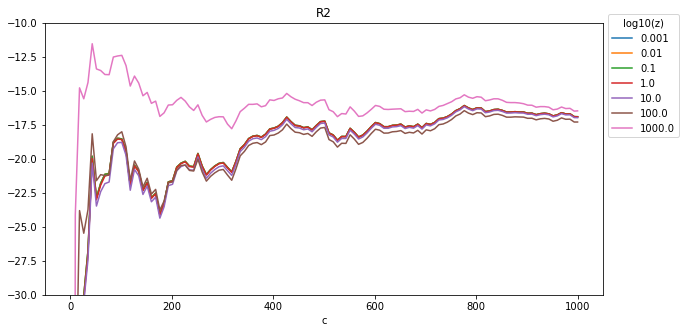

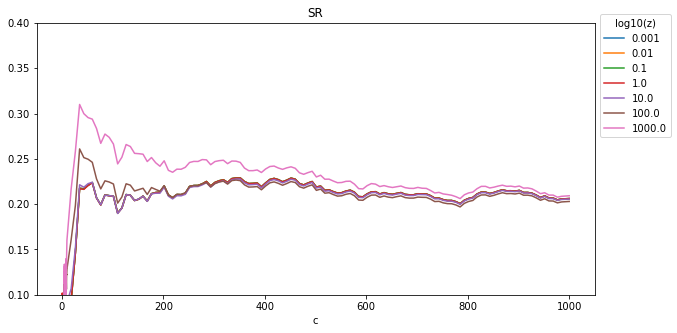

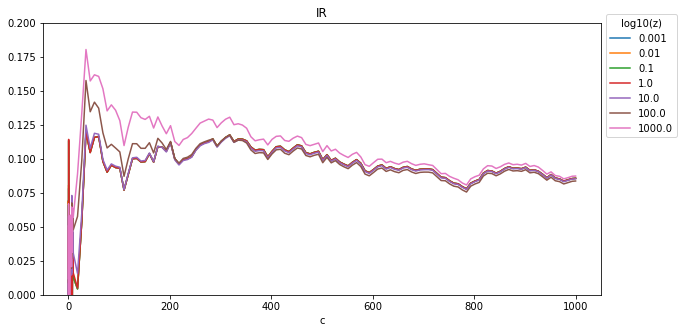

In [9]:
result.set_index("c").groupby("log10(z)")["R2"].plot(ylim=(-30,-10), figsize=(10,5), title="R2")
plt.legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
plt.show()

result.set_index("c").groupby("log10(z)")["SR"].plot(ylim=(0.1, 0.4), figsize=(10,5), title="SR")
plt.legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
plt.show()

result.set_index("c").groupby("log10(z)")["IR"].plot(ylim=(0,0.2), figsize=(10,5), title="IR")
plt.legend(loc="upper left", title="log10(z)", bbox_to_anchor=(1, 1.05))
plt.show()